In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Alagoas - Consumo de Cimento (t)'
start_index = 0
split_index = 203 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_AL.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - Consumo de Cimento (t),Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.635160,1.594356e+06,30.109,0.728082,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,2002.694978,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,0.574004,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.635571,1.598004e+06,27.684,0.728532,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,2002.726142,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,0.574517,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.635982,1.601652e+06,26.534,0.728982,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,2002.744322,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,0.575030,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.636393,1.605299e+06,25.109,0.729432,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,2002.746270,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,0.575544,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.636804,1.608947e+06,25.171,0.729882,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,2002.886466,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,0.576057,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34203.746404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34166.160992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34117.245244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34053.559120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


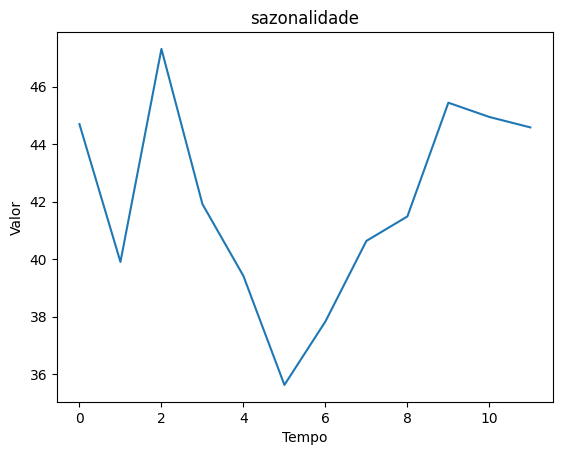

,sazonalidade
sazonalidade,
0,44.693610
1,39.905916
2,47.307738
3,41.916179
4,39.417470
5,35.630703
6,37.834664
7,40.635306
8,41.485651


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Alagoas - Consumo de Cimento (t)
0,2003-1,0.635160,1.594356e+06,0.728082,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,2002.694978,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,0.574004,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,44.693610,30.109
1,2003-2,0.635571,1.598004e+06,0.728532,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,2002.726142,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,0.574517,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,39.905916,27.684
2,2003-3,0.635982,1.601652e+06,0.728982,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,2002.744322,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,0.575030,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,47.307738,26.534
3,2003-4,0.636393,1.605299e+06,0.729432,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,2002.746270,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,0.575544,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,41.916179,25.109
4,2003-5,0.636804,1.608947e+06,0.729882,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,2002.886466,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,0.576057,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,39.417470,25.171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34203.746404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.417470,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34166.160992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.630703,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34117.245244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.834664,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34053.559120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.635306,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      29.095
1      25.241
2      29.040
3      25.685
4      21.197
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Alagoas - Consumo de Cimento (t), Length: 249, dtype: float64

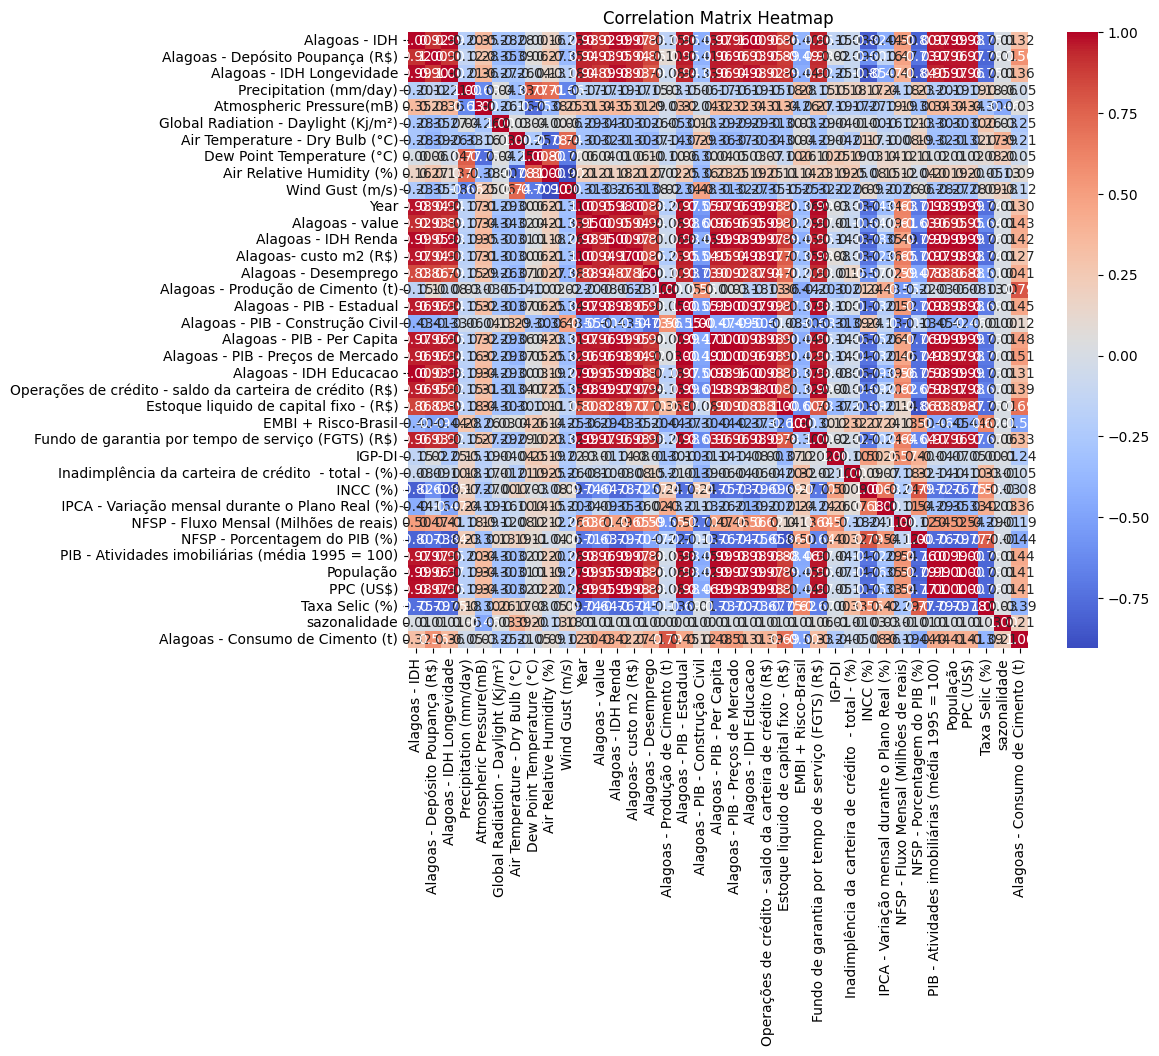

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Alagoas - IDH,1.045972e+10
1,Alagoas - Depósito Poupança (R$),1.005577e+05
2,Alagoas - IDH Longevidade,1.269119e+09
3,Precipitation (mm/day),2.033155e+02
4,Atmospheric Pressure(mB),2.317433e+07
5,Global Radiation - Daylight (Kj/m²),1.502514e+01
6,Air Temperature - Dry Bulb (°C),5.885011e+06
7,Dew Point Temperature (°C),4.381034e+06
8,Air Relative Humidity (%),3.055038e+06
9,Wind Gust (m/s),1.525794e+03


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 8


,Alagoas - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Alagoas - value,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,1.594356e+06,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,0.294434,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,0.574004,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,44.693610
1,1.598004e+06,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,0.296211,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,0.574517,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,39.905916
2,1.601652e+06,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,0.297521,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,0.575030,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,47.307738
3,1.605299e+06,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,0.298766,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,0.575544,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,41.916179
4,1.608947e+06,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,0.299945,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,0.576057,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,39.417470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,4.058289e+06,1.123358,1006.427825,1461.188945,24.986478,20.680433,78.161724,2.578709,0.485894,25868.510842,13.800259,25.496044,3.092032e+07,1.311426e+06,0.644147,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,40.635306
200,4.119763e+06,1.000728,1005.638527,1568.291096,25.407488,20.766278,76.760990,2.733513,0.489444,26073.322367,13.785417,25.715098,3.088859e+07,1.312128e+06,0.644155,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,41.485651
201,4.181238e+06,0.897837,1004.938803,1637.351955,25.881467,20.944524,75.524803,2.874284,0.492669,26298.235476,13.770574,25.849902,3.085686e+07,1.312829e+06,0.644163,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,45.438486
202,4.242712e+06,0.864385,1004.420112,1671.007852,26.321674,21.294188,75.195827,2.883543,0.496378,26530.052026,13.755732,25.728122,3.082513e+07,1.313530e+06,0.644171,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,44.942696


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Alagoas - value,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.600202,0.337742,0.122851,0.447062,0.678883,0.767231,0.340393,0.000000,0.000000,0.038220,0.277204,0.000000,0.020532,0.000000,0.000000,0.108706,0.014287,0.803606,0.790380,1.000000,1.000000,0.301039,1.000000,0.000000,0.000000,0.827406
1,0.599857,0.338094,0.122851,0.446694,0.678780,0.767319,0.340212,0.008634,0.005619,0.037336,0.273022,0.005789,0.040374,0.007263,0.000190,0.058377,0.004635,0.752660,0.788742,0.968938,0.921240,0.301792,0.966038,0.001495,0.003428,0.719915
2,0.599656,0.338299,0.122851,0.446479,0.678720,0.767369,0.340106,0.015001,0.010954,0.036452,0.271787,0.011578,0.060216,0.014526,0.000203,0.100305,0.000909,0.728503,0.788333,0.948438,0.873107,0.294922,0.928087,0.002989,0.006967,1.000000
3,0.599634,0.338321,0.122851,0.446456,0.678714,0.767375,0.340095,0.021055,0.015888,0.035568,0.267883,0.017368,0.080058,0.021790,0.000349,0.211591,0.000000,0.690036,0.787696,0.928794,0.851659,0.279215,0.886653,0.004484,0.010587,0.656464
4,0.609114,0.278485,0.113698,0.463207,0.705927,0.776616,0.320951,0.026783,0.020715,0.034684,0.269908,0.023157,0.099899,0.029053,0.000809,0.358835,0.002131,0.662845,0.784532,0.970421,0.823277,0.285466,0.839542,0.006327,0.014112,0.810086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.328021,0.690634,0.049851,0.184570,0.600100,0.846283,0.170010,0.930592,0.942285,0.843776,0.154649,0.919597,0.131525,0.992666,0.964083,0.164662,0.843595,0.925754,0.200335,0.437606,0.269755,0.988898,0.004294,0.987846,0.991307,0.096760
200,0.273272,0.552847,0.055249,0.291401,0.617384,0.799171,0.236884,0.947847,0.955439,0.841401,0.159731,0.913779,0.141505,0.992783,0.972616,0.166152,0.841613,0.940916,0.197374,0.449028,0.321896,0.989787,0.001943,0.990212,0.993698,0.092442
201,0.227337,0.430697,0.058729,0.411673,0.653273,0.757593,0.297697,0.963522,0.969884,0.839026,0.162858,0.907961,0.151485,0.992900,0.982801,0.171580,0.899079,0.983770,0.173835,0.471116,0.386916,0.966651,0.001563,0.992579,0.995919,0.063859
202,0.212402,0.340150,0.060425,0.523375,0.723677,0.746529,0.301697,0.981552,0.984772,0.836651,0.160033,0.902143,0.161465,0.993017,0.992089,0.177868,0.970196,0.973718,0.162834,0.496672,0.432519,0.988004,0.001600,0.996289,0.997943,0.046786


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Alagoas - value,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.600202,0.337742,0.122851,0.447062,0.678883,0.767231,0.340393,0.000000,0.000000,0.038220,0.277204,0.000000,0.020532,0.000000,0.000000,0.108706,0.014287,0.803606,0.790380,1.000000,1.000000,0.301039,1.000000,0.000000,0.000000,0.827406
1,0.599857,0.338094,0.122851,0.446694,0.678780,0.767319,0.340212,0.008634,0.005619,0.037336,0.273022,0.005789,0.040374,0.007263,0.000190,0.058377,0.004635,0.752660,0.788742,0.968938,0.921240,0.301792,0.966038,0.001495,0.003428,0.719915
2,0.599656,0.338299,0.122851,0.446479,0.678720,0.767369,0.340106,0.015001,0.010954,0.036452,0.271787,0.011578,0.060216,0.014526,0.000203,0.100305,0.000909,0.728503,0.788333,0.948438,0.873107,0.294922,0.928087,0.002989,0.006967,1.000000
3,0.599634,0.338321,0.122851,0.446456,0.678714,0.767375,0.340095,0.021055,0.015888,0.035568,0.267883,0.017368,0.080058,0.021790,0.000349,0.211591,0.000000,0.690036,0.787696,0.928794,0.851659,0.279215,0.886653,0.004484,0.010587,0.656464
4,0.609114,0.278485,0.113698,0.463207,0.705927,0.776616,0.320951,0.026783,0.020715,0.034684,0.269908,0.023157,0.099899,0.029053,0.000809,0.358835,0.002131,0.662845,0.784532,0.970421,0.823277,0.285466,0.839542,0.006327,0.014112,0.810086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.249097,0.647542,0.054102,0.171843,0.565709,0.826453,0.229760,0.790534,0.830597,0.873789,0.074812,0.972276,0.036066,0.995245,0.905889,0.187214,0.772088,0.306496,0.228511,0.005731,0.000000,0.770932,0.039832,0.940133,0.954021,0.142213
188,0.294468,0.544410,0.057057,0.266587,0.604854,0.801109,0.301280,0.793921,0.835995,0.871111,0.089175,0.969885,0.041186,0.994566,0.910701,0.197767,0.765287,0.374969,0.204051,0.037761,0.029504,0.843110,0.036772,0.946259,0.957505,0.121167
189,0.333742,0.485808,0.058330,0.351129,0.659774,0.793543,0.310169,0.797504,0.842008,0.868433,0.105018,0.967495,0.046306,0.993887,0.918025,0.203626,0.822408,0.426663,0.163703,0.087044,0.043125,0.852836,0.032169,0.952386,0.960752,0.085226
190,0.425284,0.420281,0.058757,0.431162,0.743391,0.809401,0.282027,0.803275,0.848478,0.865756,0.103337,0.965104,0.051425,0.993208,0.924362,0.204541,0.894295,0.491223,0.131737,0.118264,0.059756,0.901189,0.026694,0.956511,0.963720,0.124421


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      29.095
1      25.241
2      29.040
3      25.685
4      21.197
        ...  
187    55.414
188    55.039
189    63.699
190    51.896
191    50.018
Name: Alagoas - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 26)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size : split_index + 1]
test_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Alagoas - value,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,0.522551,0.393223,0.055087,0.508745,0.843579,0.839756,0.211807,0.914499,0.678372,1.000000,0.393681,0.984178,0.068624,0.977073,0.916170,0.442089,0.839309,0.068901,0.587637,0.194855,0.431209,0.413661,0.036321,0.809361,0.841791,0.468318
157,0.501523,0.435518,0.053115,0.488548,0.848559,0.854616,0.136312,0.908980,0.684251,0.994279,0.364491,0.985496,0.062905,0.977935,0.912459,0.467381,0.801704,0.032121,0.643262,0.182507,0.379453,0.455637,0.033116,0.809984,0.845267,0.411842
158,0.510938,0.514749,0.049241,0.425719,0.837510,0.882825,0.084713,0.903068,0.689913,0.988558,0.335474,0.986815,0.057187,0.978798,0.908995,0.483414,0.790541,0.022138,0.709146,0.168812,0.332832,0.444532,0.030640,0.810608,0.849072,0.445079
159,0.464912,0.610058,0.045879,0.315488,0.767598,0.893649,0.054154,0.896755,0.695620,0.982837,0.306644,0.988133,0.051468,0.979660,0.905562,0.485402,0.775928,0.029764,0.729647,0.152959,0.313954,0.426520,0.028514,0.811231,0.852964,0.424429
160,0.429283,0.734104,0.044568,0.195124,0.676007,0.895335,0.029376,0.890009,0.701100,0.977116,0.278014,0.989452,0.045749,0.980523,0.902608,0.480289,0.772954,0.056928,0.729821,0.137613,0.294856,0.443124,0.026816,0.811034,0.856928,0.481307
161,0.355930,0.807278,0.045629,0.128351,0.599529,0.875732,0.056990,0.882880,0.706551,0.971395,0.249595,0.990770,0.040031,0.981385,0.899226,0.466293,0.770874,0.061888,0.716852,0.163171,0.308016,0.437764,0.025008,0.810837,0.860686,0.545277
162,0.307048,0.782097,0.048766,0.132727,0.546379,0.833010,0.142135,0.875402,0.711098,0.965673,0.221402,0.992089,0.034312,0.982248,0.896766,0.446692,0.763405,0.028761,0.746600,0.115114,0.297600,0.424379,0.024308,0.810640,0.864433,0.411731
163,0.267928,0.704827,0.052449,0.193181,0.542299,0.795336,0.246351,0.867572,0.715577,0.959952,0.193445,0.993407,0.028593,0.983110,0.894216,0.423280,0.760489,0.049338,0.803166,0.099148,0.258616,0.427657,0.024210,0.813009,0.868468,0.517393
164,0.273304,0.590859,0.055346,0.296450,0.572236,0.757427,0.362121,0.861408,0.720324,0.954231,0.165739,0.994726,0.022875,0.983973,0.892500,0.387661,0.754812,0.076797,0.850835,0.092609,0.249254,0.410864,0.025786,0.815379,0.872546,0.484026
165,0.294690,0.474608,0.058486,0.400815,0.598498,0.717032,0.436064,0.854965,0.725249,0.948510,0.145022,0.996044,0.017156,0.984835,0.891376,0.351781,0.801517,0.077481,0.875483,0.088481,0.255443,0.380278,0.027984,0.817748,0.876542,0.460061


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 26)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2033033805, 3505804795, 4177026678, 2311814247, 2076238812, 3278923289, 302767512, 2302593873, 1105546517, 2703376966]


Step: 0 ___________________________________________
val_loss: 85.477783203125
winner_seed: 2033033805


Step: 1 ___________________________________________
val_loss: 75.5557632446289
winner_seed: 3505804795


Step: 2 ___________________________________________
val_loss: 66.15563201904297
winner_seed: 4177026678


Step: 3 ___________________________________________
val_loss: 144.39080810546875


Step: 4 ___________________________________________
val_loss: 77.40631866455078


Step: 5 ___________________________________________
val_loss: 118.47758483886719


Step: 6 ___________________________________________
val_loss: 43.73052978515625
winner_seed: 302767512


Step: 7 ___________________________________________
val_loss: 131.37838745117188


Step: 8 ___________________________________________
val_loss: 202.67356872558594


Step: 9 ____________________________________

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 98ms/step - loss: 1550.0264 - val_loss: 102.1704
Epoch 2/10000
5/5 [==============================] - 0s 9ms/step - loss: 250.0656 - val_loss: 76.9032
Epoch 3/10000
5/5 [==============================] - 0s 9ms/step - loss: 277.1653 - val_loss: 74.4970
Epoch 4/10000
5/5 [==============================] - 0s 9ms/step - loss: 239.9383 - val_loss: 65.8469
Epoch 5/10000
5/5 [==============================] - 0s 9ms/step - loss: 249.5479 - val_loss: 53.1411
Epoch 6/10000
5/5 [==============================] - 0s 10ms/step - loss: 240.9088 - val_loss: 73.5966
Epoch 7/10000
5/5 [==============================] - 0s 9ms/step - loss: 230.7032 - val_loss: 115.2101
Epoch 8/10000
5/5 [==============================] - 0s 9ms/step - loss: 248.3131 - val_loss: 77.6173
Epoch 9/10000
5/5 [==============================] - 0s 9ms/step - loss: 236.5496 - val_loss: 89.9810
Epoch 10/10000
5/5 [==============================] - 0s 9ms/step - loss: 224

5/5 [==============================] - 0s 9ms/step - loss: 61.0573 - val_loss: 342.5384
Epoch 81/10000
5/5 [==============================] - 0s 9ms/step - loss: 98.3311 - val_loss: 399.7257
Epoch 82/10000
5/5 [==============================] - 0s 9ms/step - loss: 45.7175 - val_loss: 205.8439
Epoch 83/10000
5/5 [==============================] - 0s 9ms/step - loss: 133.1132 - val_loss: 383.0376
Epoch 84/10000
5/5 [==============================] - 0s 9ms/step - loss: 56.1889 - val_loss: 326.3575
Epoch 85/10000
5/5 [==============================] - 0s 9ms/step - loss: 42.0578 - val_loss: 418.4630
Epoch 86/10000
5/5 [==============================] - 0s 9ms/step - loss: 40.0957 - val_loss: 512.7897
Epoch 87/10000
5/5 [==============================] - 0s 9ms/step - loss: 37.0608 - val_loss: 443.6715
Epoch 88/10000
5/5 [==============================] - 0s 9ms/step - loss: 47.3248 - val_loss: 364.9276
Epoch 89/10000
5/5 [==============================] - 0s 9ms/step - loss: 37.8708 - val

5/5 [==============================] - 0s 10ms/step - loss: 28.3500 - val_loss: 185.3731
Epoch 159/10000
5/5 [==============================] - 0s 10ms/step - loss: 33.7108 - val_loss: 201.9177
Epoch 160/10000
5/5 [==============================] - 0s 10ms/step - loss: 32.1768 - val_loss: 247.1716
Epoch 161/10000
5/5 [==============================] - 0s 10ms/step - loss: 31.0492 - val_loss: 282.3591
Epoch 162/10000
5/5 [==============================] - 0s 10ms/step - loss: 29.3694 - val_loss: 330.5282
Epoch 163/10000
5/5 [==============================] - 0s 9ms/step - loss: 33.0951 - val_loss: 178.3885
Epoch 164/10000
5/5 [==============================] - 0s 10ms/step - loss: 29.4581 - val_loss: 243.0796
Epoch 165/10000
5/5 [==============================] - 0s 10ms/step - loss: 28.3763 - val_loss: 317.9088
Epoch 166/10000
5/5 [==============================] - 0s 10ms/step - loss: 26.9639 - val_loss: 158.1978
Epoch 167/10000
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 10ms/step - loss: 26.1764 - val_loss: 243.8733
Epoch 237/10000
5/5 [==============================] - 0s 10ms/step - loss: 28.0372 - val_loss: 249.9506
Epoch 238/10000
5/5 [==============================] - 0s 10ms/step - loss: 26.4089 - val_loss: 207.8702
Epoch 239/10000
5/5 [==============================] - 0s 9ms/step - loss: 23.3917 - val_loss: 241.4556
Epoch 240/10000
5/5 [==============================] - 0s 9ms/step - loss: 22.8777 - val_loss: 207.9506
Epoch 241/10000
5/5 [==============================] - 0s 9ms/step - loss: 31.4578 - val_loss: 143.7484
Epoch 242/10000
5/5 [==============================] - 0s 9ms/step - loss: 26.0671 - val_loss: 301.4895
Epoch 243/10000
5/5 [==============================] - 0s 9ms/step - loss: 27.1154 - val_loss: 196.0570
Epoch 244/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.1595 - val_loss: 229.0766
Epoch 245/10000
5/5 [==============================] - 0s 9ms/step - loss: 2

5/5 [==============================] - 0s 10ms/step - loss: 18.6949 - val_loss: 156.4185
Epoch 315/10000
5/5 [==============================] - 0s 10ms/step - loss: 21.7330 - val_loss: 191.2977
Epoch 316/10000
5/5 [==============================] - 0s 10ms/step - loss: 19.1852 - val_loss: 148.5431
Epoch 317/10000
5/5 [==============================] - 0s 10ms/step - loss: 21.0588 - val_loss: 152.6013
Epoch 318/10000
5/5 [==============================] - 0s 10ms/step - loss: 18.8524 - val_loss: 221.6604
Epoch 319/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.1693 - val_loss: 156.8912
Epoch 320/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.4495 - val_loss: 297.4938
Epoch 321/10000
5/5 [==============================] - 0s 9ms/step - loss: 22.5185 - val_loss: 207.8528
Epoch 322/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.0211 - val_loss: 250.0320
Epoch 323/10000
5/5 [==============================] - 0s 10ms/step - loss

5/5 [==============================] - 0s 9ms/step - loss: 17.1298 - val_loss: 206.1044
Epoch 393/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.3587 - val_loss: 210.0761
Epoch 394/10000
5/5 [==============================] - 0s 10ms/step - loss: 17.3552 - val_loss: 179.0097
Epoch 395/10000
5/5 [==============================] - 0s 8ms/step - loss: 18.6021 - val_loss: 165.0637
Epoch 396/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.7378 - val_loss: 237.6591
Epoch 397/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.5874 - val_loss: 156.0143
Epoch 398/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.2078 - val_loss: 199.0703
Epoch 399/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.2945 - val_loss: 225.9894
Epoch 400/10000
5/5 [==============================] - 0s 8ms/step - loss: 18.2052 - val_loss: 196.1453
Epoch 401/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.0

5/5 [==============================] - 0s 10ms/step - loss: 15.0765 - val_loss: 167.1582
Epoch 471/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.5313 - val_loss: 141.7258
Epoch 472/10000
5/5 [==============================] - 0s 10ms/step - loss: 23.2644 - val_loss: 167.4664
Epoch 473/10000
5/5 [==============================] - 0s 9ms/step - loss: 20.1548 - val_loss: 202.8054
Epoch 474/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.8285 - val_loss: 177.9180
Epoch 475/10000
5/5 [==============================] - 0s 10ms/step - loss: 18.6050 - val_loss: 196.4390
Epoch 476/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.2052 - val_loss: 140.1532
Epoch 477/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.3286 - val_loss: 183.6535
Epoch 478/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.2731 - val_loss: 201.2444
Epoch 479/10000
5/5 [==============================] - 0s 9ms/step - loss: 1

Epoch 549/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.0936 - val_loss: 170.8862
Epoch 550/10000
5/5 [==============================] - 0s 10ms/step - loss: 17.6934 - val_loss: 189.0170
Epoch 551/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.1879 - val_loss: 161.6923
Epoch 552/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.9928 - val_loss: 158.5496
Epoch 553/10000
5/5 [==============================] - 0s 10ms/step - loss: 17.3694 - val_loss: 152.8842
Epoch 554/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.1014 - val_loss: 169.9544
Epoch 555/10000
5/5 [==============================] - 0s 10ms/step - loss: 16.4049 - val_loss: 134.5162
Epoch 556/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.6447 - val_loss: 142.7487
Epoch 557/10000
5/5 [==============================] - 0s 10ms/step - loss: 16.1570 - val_loss: 166.4205
Epoch 558/10000
5/5 [==============================] - 0s 

5/5 [==============================] - 0s 9ms/step - loss: 16.1257 - val_loss: 160.3721
Epoch 628/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.7263 - val_loss: 139.0088
Epoch 629/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.2322 - val_loss: 161.2974
Epoch 630/10000
5/5 [==============================] - 0s 10ms/step - loss: 17.4076 - val_loss: 159.5314
Epoch 631/10000
5/5 [==============================] - 0s 10ms/step - loss: 16.4178 - val_loss: 178.8382
Epoch 632/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.3417 - val_loss: 205.5285
Epoch 633/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.2207 - val_loss: 188.8207
Epoch 634/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.8398 - val_loss: 155.8484
Epoch 635/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.6455 - val_loss: 147.9382
Epoch 636/10000
5/5 [==============================] - 0s 10ms/step - loss: 15

5/5 [==============================] - 0s 10ms/step - loss: 14.6951 - val_loss: 164.1879
Epoch 706/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.9876 - val_loss: 138.6053
Epoch 707/10000
5/5 [==============================] - 0s 11ms/step - loss: 15.0293 - val_loss: 162.3340
Epoch 708/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.9993 - val_loss: 129.1450
Epoch 709/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.9842 - val_loss: 156.5814
Epoch 710/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.1219 - val_loss: 172.9701
Epoch 711/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.9518 - val_loss: 172.6579
Epoch 712/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.7343 - val_loss: 169.8225
Epoch 713/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.0243 - val_loss: 160.5219
Epoch 714/10000
5/5 [==============================] - 0s 9ms/step - loss:

5/5 [==============================] - 0s 10ms/step - loss: 14.1044 - val_loss: 168.0617
Epoch 784/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.8233 - val_loss: 181.2967
Epoch 785/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.6512 - val_loss: 135.7213
Epoch 786/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.5182 - val_loss: 155.4492
Epoch 787/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.4389 - val_loss: 152.4125
Epoch 788/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.9290 - val_loss: 170.5509
Epoch 789/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.3915 - val_loss: 112.0547
Epoch 790/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.6219 - val_loss: 166.9561
Epoch 791/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.5891 - val_loss: 159.6240
Epoch 792/10000
5/5 [==============================] - 0s 10ms/step - loss: 1

5/5 [==============================] - 0s 10ms/step - loss: 15.1707 - val_loss: 164.0759
Epoch 862/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.4617 - val_loss: 140.2674
Epoch 863/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.5052 - val_loss: 168.6219
Epoch 864/10000
5/5 [==============================] - 0s 12ms/step - loss: 13.0731 - val_loss: 146.5932
Epoch 865/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.9335 - val_loss: 147.4559
Epoch 866/10000
5/5 [==============================] - 0s 11ms/step - loss: 12.2499 - val_loss: 179.3001
Epoch 867/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.4122 - val_loss: 158.9536
Epoch 868/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.2040 - val_loss: 140.3352
Epoch 869/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.1606 - val_loss: 131.1413
Epoch 870/10000
5/5 [==============================] - 0s 10ms/step - l

5/5 [==============================] - 0s 9ms/step - loss: 11.9167 - val_loss: 130.1383
Epoch 940/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.4887 - val_loss: 144.1258
Epoch 941/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.1293 - val_loss: 112.7983
Epoch 942/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.4224 - val_loss: 126.8667
Epoch 943/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.2469 - val_loss: 159.9226
Epoch 944/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.1219 - val_loss: 165.1994
Epoch 945/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.8287 - val_loss: 150.6257
Epoch 946/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.8569 - val_loss: 145.0105
Epoch 947/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.0632 - val_loss: 127.0126
Epoch 948/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.21

5/5 [==============================] - 0s 10ms/step - loss: 10.1861 - val_loss: 138.8506
Epoch 1018/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.6080 - val_loss: 139.6945
Epoch 1019/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.3176 - val_loss: 123.6721
Epoch 1020/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.2066 - val_loss: 139.7836
Epoch 1021/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.3627 - val_loss: 129.0594
Epoch 1022/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.1418 - val_loss: 132.9879
Epoch 1023/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.1013 - val_loss: 148.9101
Epoch 1024/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.1340 - val_loss: 153.1290
Epoch 1025/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.0371 - val_loss: 126.8759
Epoch 1026/10000
5/5 [==============================] - 0s 10ms/step -

5/5 [==============================] - 0s 11ms/step - loss: 12.4976 - val_loss: 138.4313
Epoch 1096/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.2188 - val_loss: 109.0510
Epoch 1097/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.5937 - val_loss: 158.1528
Epoch 1098/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.2957 - val_loss: 143.3443
Epoch 1099/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.7138 - val_loss: 139.0446
Epoch 1100/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.4482 - val_loss: 127.4975
Epoch 1101/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.1863 - val_loss: 154.0672
Epoch 1102/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.4488 - val_loss: 116.6824
Epoch 1103/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.1586 - val_loss: 97.7565
Epoch 1104/10000
5/5 [==============================] - 0s 9ms/step - lo

Epoch 1173/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.7726 - val_loss: 101.2483
Epoch 1174/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.4410 - val_loss: 127.6821
Epoch 1175/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.7079 - val_loss: 106.9583
Epoch 1176/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.9454 - val_loss: 114.3897
Epoch 1177/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.7283 - val_loss: 101.5735
Epoch 1178/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.3182 - val_loss: 121.2087
Epoch 1179/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.0926 - val_loss: 111.3445
Epoch 1180/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.4531 - val_loss: 123.2493
Epoch 1181/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.0498 - val_loss: 130.1667
Epoch 1182/10000
5/5 [==============================]

5/5 [==============================] - 0s 9ms/step - loss: 10.9439 - val_loss: 92.8666
Epoch 1252/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.7456 - val_loss: 136.1203
Epoch 1253/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.1750 - val_loss: 111.0703
Epoch 1254/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.1303 - val_loss: 114.8033
Epoch 1255/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.8775 - val_loss: 133.4473
Epoch 1256/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.9217 - val_loss: 120.3878
Epoch 1257/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.3574 - val_loss: 108.4447
Epoch 1258/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.0113 - val_loss: 105.1261
Epoch 1259/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.5037 - val_loss: 119.1220
Epoch 1260/10000
5/5 [==============================] - 0s 9ms/step - l

5/5 [==============================] - 0s 10ms/step - loss: 12.3522 - val_loss: 118.0836
Epoch 1330/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.9039 - val_loss: 90.8699
Epoch 1331/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.4680 - val_loss: 90.5692
Epoch 1332/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.7297 - val_loss: 92.2173
Epoch 1333/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.2540 - val_loss: 72.6853
Epoch 1334/10000
5/5 [==============================] - 0s 10ms/step - loss: 155.5940 - val_loss: 79.4348
Epoch 1335/10000
5/5 [==============================] - 0s 10ms/step - loss: 117.8120 - val_loss: 105.6040
Epoch 1336/10000
5/5 [==============================] - 0s 10ms/step - loss: 62.2186 - val_loss: 200.4058
Epoch 1337/10000
5/5 [==============================] - 0s 9ms/step - loss: 49.1405 - val_loss: 159.7823
Epoch 1338/10000
5/5 [==============================] - 0s 9ms/step -

Epoch 1407/10000
5/5 [==============================] - 0s 9ms/step - loss: 24.1818 - val_loss: 167.6931
Epoch 1408/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.6630 - val_loss: 195.6367
Epoch 1409/10000
5/5 [==============================] - 0s 9ms/step - loss: 22.3047 - val_loss: 253.9498
Epoch 1410/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.2903 - val_loss: 195.5584
Epoch 1411/10000
5/5 [==============================] - 0s 9ms/step - loss: 22.2204 - val_loss: 239.7273
Epoch 1412/10000
5/5 [==============================] - 0s 9ms/step - loss: 20.5479 - val_loss: 268.6695
Epoch 1413/10000
5/5 [==============================] - 0s 9ms/step - loss: 31.4590 - val_loss: 170.7142
Epoch 1414/10000
5/5 [==============================] - 0s 9ms/step - loss: 22.8365 - val_loss: 165.2252
Epoch 1415/10000
5/5 [==============================] - 0s 10ms/step - loss: 19.4612 - val_loss: 248.8068
Epoch 1416/10000
5/5 [==============================] 

Epoch 1485/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.4409 - val_loss: 209.6744
Epoch 1486/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.1966 - val_loss: 161.7132
Epoch 1487/10000
5/5 [==============================] - 0s 8ms/step - loss: 18.5325 - val_loss: 252.4414
Epoch 1488/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.4962 - val_loss: 194.4651
Epoch 1489/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.7568 - val_loss: 179.8844
Epoch 1490/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.1026 - val_loss: 160.2827
Epoch 1491/10000
5/5 [==============================] - 0s 8ms/step - loss: 18.1597 - val_loss: 214.0816
Epoch 1492/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.4376 - val_loss: 135.3247
Epoch 1493/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.3209 - val_loss: 132.4515
Epoch 1494/10000
5/5 [==============================] -

Epoch 1563/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.6979 - val_loss: 158.1671
Epoch 1564/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.8337 - val_loss: 199.9950
Epoch 1565/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.0311 - val_loss: 166.5024
Epoch 1566/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.5072 - val_loss: 185.1424
Epoch 1567/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.4297 - val_loss: 190.9456
Epoch 1568/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.3284 - val_loss: 141.9880
Epoch 1569/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.4117 - val_loss: 197.3503
Epoch 1570/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.7902 - val_loss: 151.1469
Epoch 1571/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.3759 - val_loss: 209.8156
Epoch 1572/10000
5/5 [==============================] -

Epoch 1641/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.0917 - val_loss: 248.5820
Epoch 1642/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.0307 - val_loss: 168.5095
Epoch 1643/10000
5/5 [==============================] - 0s 10ms/step - loss: 16.6534 - val_loss: 170.3545
Epoch 1644/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.9932 - val_loss: 205.3505
Epoch 1645/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.0195 - val_loss: 212.7824
Epoch 1646/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.5765 - val_loss: 221.9913
Epoch 1647/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.1256 - val_loss: 152.3999
Epoch 1648/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.3445 - val_loss: 144.2032
Epoch 1649/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.8302 - val_loss: 184.7580
Epoch 1650/10000
5/5 [==============================

Epoch 1719/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.7354 - val_loss: 175.9403
Epoch 1720/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.7887 - val_loss: 163.5945
Epoch 1721/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.5081 - val_loss: 166.8152
Epoch 1722/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.0612 - val_loss: 210.2586
Epoch 1723/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.7661 - val_loss: 170.3410
Epoch 1724/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.0656 - val_loss: 158.1114
Epoch 1725/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.5676 - val_loss: 151.5916
Epoch 1726/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.5049 - val_loss: 128.0903
Epoch 1727/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.7099 - val_loss: 168.6069
Epoch 1728/10000
5/5 [==============================]

Epoch 1797/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.3805 - val_loss: 136.3558
Epoch 1798/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.6099 - val_loss: 170.7896
Epoch 1799/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.1707 - val_loss: 152.8170
Epoch 1800/10000
5/5 [==============================] - 0s 11ms/step - loss: 13.3457 - val_loss: 173.8686
Epoch 1801/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.2840 - val_loss: 179.4907
Epoch 1802/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.8966 - val_loss: 136.4794
Epoch 1803/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.7340 - val_loss: 175.7719
Epoch 1804/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.3621 - val_loss: 137.5849
Epoch 1805/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.7370 - val_loss: 137.1437
Epoch 1806/10000
5/5 [============================

5/5 [==============================] - 0s 10ms/step - loss: 12.9863 - val_loss: 140.2249
Epoch 1875/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.4283 - val_loss: 123.4379
Epoch 1876/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.5940 - val_loss: 111.9371
Epoch 1877/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.0420 - val_loss: 143.4012
Epoch 1878/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.2474 - val_loss: 126.2344
Epoch 1879/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.2749 - val_loss: 165.3916
Epoch 1880/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.8811 - val_loss: 159.9143
Epoch 1881/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.1109 - val_loss: 155.7491
Epoch 1882/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.3603 - val_loss: 190.6262
Epoch 1883/10000
5/5 [==============================] - 0s 10ms

Epoch 1952/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.5804 - val_loss: 136.6202
Epoch 1953/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.9123 - val_loss: 130.8789
Epoch 1954/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.3908 - val_loss: 117.3490
Epoch 1955/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.9501 - val_loss: 144.4745
Epoch 1956/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.5286 - val_loss: 127.9128
Epoch 1957/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.6885 - val_loss: 108.9885
Epoch 1958/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.4177 - val_loss: 105.4401
Epoch 1959/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.2768 - val_loss: 155.2307
Epoch 1960/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.3271 - val_loss: 151.4208
Epoch 1961/10000
5/5 [==============================] -

Epoch 2030/10000
5/5 [==============================] - 0s 12ms/step - loss: 12.3566 - val_loss: 144.9413
Epoch 2031/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.4007 - val_loss: 147.6000
Epoch 2032/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.3824 - val_loss: 124.1533
Epoch 2033/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.3379 - val_loss: 158.6366
Epoch 2034/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.3614 - val_loss: 195.5763
Epoch 2035/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.0446 - val_loss: 127.2881
Epoch 2036/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.4014 - val_loss: 121.3482
Epoch 2037/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.6069 - val_loss: 142.2516
Epoch 2038/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.1553 - val_loss: 138.6339
Epoch 2039/10000
5/5 [==============================

Epoch 2108/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.0756 - val_loss: 138.0783
Epoch 2109/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.6395 - val_loss: 191.9270
Epoch 2110/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.4298 - val_loss: 111.6372
Epoch 2111/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.7758 - val_loss: 148.0274
Epoch 2112/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.3436 - val_loss: 126.1858
Epoch 2113/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.3524 - val_loss: 117.6852
Epoch 2114/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.6724 - val_loss: 158.1211
Epoch 2115/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.2133 - val_loss: 121.8080
Epoch 2116/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.4287 - val_loss: 112.0365
Epoch 2117/10000
5/5 [==============================] 

Epoch 2186/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.7672 - val_loss: 136.6210
Epoch 2187/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.7752 - val_loss: 141.0193
Epoch 2188/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.8365 - val_loss: 154.5233
Epoch 2189/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.8740 - val_loss: 150.5468
Epoch 2190/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.6443 - val_loss: 166.6944
Epoch 2191/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.0524 - val_loss: 128.9283
Epoch 2192/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.7130 - val_loss: 131.3862
Epoch 2193/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.3919 - val_loss: 155.7719
Epoch 2194/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.5797 - val_loss: 190.4636
Epoch 2195/10000
5/5 [==============================] - 0s

5/5 [==============================] - 0s 8ms/step - loss: 10.3634 - val_loss: 157.6270
Epoch 2265/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.4925 - val_loss: 131.8799
Epoch 2266/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.4260 - val_loss: 168.1529
Epoch 2267/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.9143 - val_loss: 151.5821
Epoch 2268/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.6862 - val_loss: 159.0304
Epoch 2269/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.8497 - val_loss: 133.2987
Epoch 2270/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.9890 - val_loss: 151.7078
Epoch 2271/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.3821 - val_loss: 153.8475
Epoch 2272/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.8827 - val_loss: 138.0694
Epoch 2273/10000
5/5 [==============================] - 0s 9ms/step - loss: 

5/5 [==============================] - 0s 9ms/step - loss: 9.8233 - val_loss: 162.8969
Epoch 2343/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.3707 - val_loss: 139.4609
Epoch 2344/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.4039 - val_loss: 136.9720
Epoch 2345/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.6626 - val_loss: 134.6814
Epoch 2346/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.4750 - val_loss: 120.4605
Epoch 2347/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.7307 - val_loss: 140.1759
Epoch 2348/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.6083 - val_loss: 138.0270
Epoch 2349/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.9591 - val_loss: 118.4089
Epoch 2350/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.7334 - val_loss: 143.0821
Epoch 2351/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.28

5/5 [==============================] - 0s 8ms/step - loss: 8.4475 - val_loss: 127.6418
Epoch 2421/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.5844 - val_loss: 105.2076
Epoch 2422/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.2365 - val_loss: 175.8884
Epoch 2423/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.4105 - val_loss: 157.4719
Epoch 2424/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.3439 - val_loss: 145.0207
Epoch 2425/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.2462 - val_loss: 156.6395
Epoch 2426/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.3772 - val_loss: 155.3960
Epoch 2427/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.9320 - val_loss: 141.8202
Epoch 2428/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.0313 - val_loss: 171.8085
Epoch 2429/10000
5/5 [==============================] - 0s 10ms/step - loss: 8

5/5 [==============================] - 0s 11ms/step - loss: 7.3986 - val_loss: 134.0658
Epoch 2499/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.0146 - val_loss: 166.9411
Epoch 2500/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.3844 - val_loss: 141.4610
Epoch 2501/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.8881 - val_loss: 145.1252
Epoch 2502/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.4796 - val_loss: 138.1202
Epoch 2503/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.1087 - val_loss: 144.7933
Epoch 2504/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.0094 - val_loss: 140.7412
Epoch 2505/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.6797 - val_loss: 153.2918
Epoch 2506/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.1658 - val_loss: 128.0898
Epoch 2507/10000
5/5 [==============================] - 0s 9ms/step - loss: 

5/5 [==============================] - 0s 11ms/step - loss: 7.4568 - val_loss: 154.2821
Epoch 2577/10000
5/5 [==============================] - 0s 11ms/step - loss: 7.0721 - val_loss: 122.7453
Epoch 2578/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.1215 - val_loss: 136.8712
Epoch 2579/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.6693 - val_loss: 146.7677
Epoch 2580/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.8880 - val_loss: 122.1781
Epoch 2581/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.8773 - val_loss: 126.4578
Epoch 2582/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.1983 - val_loss: 145.6814
Epoch 2583/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.3560 - val_loss: 154.6433
Epoch 2584/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.5775 - val_loss: 105.8701
Epoch 2585/10000
5/5 [==============================] - 0s 9ms/step - los

5/5 [==============================] - 0s 9ms/step - loss: 17.1310 - val_loss: 180.1435
Epoch 2655/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.0265 - val_loss: 156.8542
Epoch 2656/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.4381 - val_loss: 199.2480
Epoch 2657/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.6118 - val_loss: 135.2868
Epoch 2658/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.1317 - val_loss: 144.9229
Epoch 2659/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.1464 - val_loss: 178.2832
Epoch 2660/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.6756 - val_loss: 157.3240
Epoch 2661/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.7832 - val_loss: 163.5283
Epoch 2662/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.7164 - val_loss: 128.1728
Epoch 2663/10000
5/5 [==============================] - 0s 10ms/step 

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,46.050121,45.224777,45.406502,43.914089,41.319996,37.888023,39.05246,43.361095,46.906036,49.231964,50.378479,46.731853
Target,50.213,44.866,53.96,46.658,44.643,44.571,47.848,47.45,48.431,50.451,49.062,48.425
Error,4.16288,0.358776,8.553497,2.743912,3.323006,6.682976,8.79554,4.088905,1.524963,1.219036,1.316479,1.693146


In [54]:
display(mae)
display(mape)

3.7052596

0.07667028

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[535.4654]] - Target[576.578]| =  Error: [[41.11261]]; MAPE:[[0.07130451]]


[array([[41.11261]], dtype=float32)]

41.11261

0.07130451